# Interactive Security Findings Analysis Pipeline

This notebook implements an interactive pipeline for grouping security findings and suggesting aggregated solutions using machine learning techniques.

## Data Loading and Preprocessing

In [19]:
import string
import random
import pandas as pd
import numpy as np
from pathlib import Path

# Load sample data (replace this with your actual data loading)
fake = pd.DataFrame({
    'id': range(1, 101),
    'description_for_embedding': [
        f"{'JS' if i % 3 == 0 else 'Python' if i % 3 == 1 else 'Java'} security issue: {['XSS vulnerability', 'SQL injection', 'Outdated package', 'Insecure authentication'][i % 4]}"
        for i in range(100)
    ],
    'severity': np.random.choice(['Low', 'Medium', 'High'], 100)
})

findings = pd.read_json(Path("../../data/VulnerabilityReport_all_llama3_instruct.json"))
# add id
findings['id'] = range(1, len(findings) + 1)

# describtion_str
findings['description_str'] = findings['description'].apply(lambda x: "".join([s for s in x]).replace("\n"," ").strip())
# findings['description_for_embedding'] = findings['description_str'] + findings['solution'].apply(lambda x: x['short_description'].replace("\n"," ").strip())
#findings['description_for_embedding'] = findings['solution'].apply(lambda x: " ".join([II.replace(";", " ").replace("\n", " ").replace("-", " ").strip() for II in x["search_terms"].split("- ")]).strip())#.replace(";"," ").replace("\n"," ").replace("-"," ").strip())

import re

def process_search_terms(search_terms): # Frag nicht wie kompliziert
    items = [x for x in re.split(r'\s*-\s*', search_terms)]
    placeholder = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
    cleaned_items = [re.sub(r'[;\n]' , ' ', item ).replace(' ', placeholder).replace(" ", "-").replace("--", " ").replace(placeholder, " ").strip() for item in items]
    return re.sub(r'\s+', ' ', ' '.join(cleaned_items))

findings['description_for_embedding'] = findings['solution'].apply(lambda x: process_search_terms(x['search_terms']))


display(findings.head())
print(f"\nTotal findings: {len(findings)}")

findings.columns

,title,source,location_list,description,cwe_ids,cve_ids,severity,priority,category,solution,id,description_str,description_for_embedding
0,[entropy and regex for passwords or secrets],[Gitleaks],[{'file': '/builds/devsecops-sel/security-flam...,[entropy and regex for passwords or secrets],[],[],90,90,CODE,{'short_description': 'Implement a password ha...,1,entropy and regex for passwords or secrets,entropy regex password hashing secret storage ...
1,[CVE-2022-29361],[Trivy],"[Werkzeug:, , werkzeug:, ]",[** DISPUTED ** Improper parsing of HTTP reque...,[CWE-444],[CVE-2022-29361],90,80,PROGRAM,{'short_description': 'Update Pallets Werkzeug...,2,** DISPUTED ** Improper parsing of HTTP reques...,HTTP Request Smuggling CVE 2022 29361 Pallets ...
2,[out of heap memory issue due to missing limit...,[Trivy],"[curl:, , libcurl:, ]","[When curl retrieves an HTTP response, it stor...",[CWE-770],[CVE-2023-38039],80,80,SYSTEM,{'short_description': 'Update curl to the late...,3,"When curl retrieves an HTTP response, it store...",out of heap memory curl headers libcurl header...
3,[curl: HTTP/2 push headers memory-leak],[Trivy],"[curl:, , libcurl4:, ]",[When an application tells libcurl it wants to...,[],[CVE-2024-2398],80,80,LIBRARY,{'short_description': 'Upgrade to the latest v...,4,When an application tells libcurl it wants to ...,HTTP/2 push headers memory leak curl vulnerabi...
4,[There is a type confusion vulnerability relat...,[Trivy],"[libcrypto3:, , libssl3:, ]",[There is a type confusion vulnerability relat...,[],[CVE-2023-0286],80,80,LIBRARY,{'short_description': 'Upgrade to OpenSSL vers...,5,There is a type confusion vulnerability relati...,openssl x.400 address type confusion asn1_stri...



Total findings: 285


Index(['title', 'source', 'location_list', 'description', 'cwe_ids', 'cve_ids',
       'severity', 'priority', 'category', 'solution', 'id', 'description_str',
       'description_for_embedding'],
      dtype='object')

In [20]:
# 2. Text Embedding
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(findings['description_for_embedding'].tolist())

print(f"\nShape of embeddings: {embeddings.shape}")

/Users/kaiser/Desktop/Uni/SS24/Praktikum/Security-Findings-Recommender-System/src/venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.




Shape of embeddings: (285, 384)


In [ ]:
# 3. Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

max_clusters = len(findings) // 4
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

# print(f"\nInertias: {inertias}")
# print(f"Silhouette Scores: {silhouette_scores}")

In [22]:
# Elbow method
kl = KneeLocator(range(2, max_clusters + 1), inertias, curve="convex", direction="decreasing")
optimal_clusters_elbow = kl.elbow

print(f"\nOptimal number of clusters (Elbow method): {optimal_clusters_elbow}")


Optimal number of clusters (Elbow method): 14


In [23]:
# Silhouette analysis
optimal_clusters_silhouette = max(range(2, max_clusters + 1), key=lambda k: silhouette_scores[k - 2])

print(f"Optimal number of clusters (Silhouette analysis): {optimal_clusters_silhouette}")

Optimal number of clusters (Silhouette analysis): 71


## KMEANS


Chosen optimal number of clusters: 14


<Axes: title={'center': 'Cluster Sizes'}, xlabel='Cluster'>

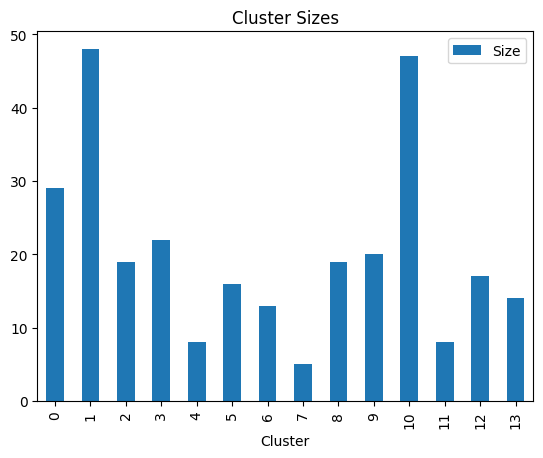

In [79]:
# Choose the optimal number of clusters based on your preference
if optimal_clusters_elbow is not None:
    optimal_clusters = optimal_clusters_elbow
else:
    optimal_clusters = optimal_clusters_silhouette

print(f"\nChosen optimal number of clusters: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# histogram of cluster sizes
df_cluster_sizes = pd.DataFrame({
    'Cluster': range(optimal_clusters),
    'Size': np.bincount(cluster_labels)
})

df_cluster_sizes = df_cluster_sizes[df_cluster_sizes['Size'] > 0]

df_cluster_sizes.plot(x='Cluster', y='Size', kind='bar', title='Cluster Sizes')

# Agglomerative Clustering

In [65]:
from sklearn.preprocessing import StandardScaler

def find_max_value ():
    tmp = []
    for i in range(0, 10):
        granularity_factor = i / 10
        tmp.append(granularity_factor * len(findings))
    return max(tmp)

# 1. Normalize the embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

# 2. Apply DBSCAN
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=30)
clusters = clustering.fit_predict(normalized_embeddings)

# 3. Get the results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

# print(f"\nDistance threshold: {find_max_value()}")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")


Distance threshold: 256.5
Number of clusters: 57
Number of noise points: 0


In [85]:
import plotly.express as px

# Perform dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
embeddings_pca = pca.fit_transform(embeddings)

# Create a DataFrame with the PCA-reduced embeddings, cluster labels, and severity
df_plot = pd.DataFrame({
    'PC1': embeddings_pca[:, 0],
    'PC2': embeddings_pca[:, 1],
    'PC3': embeddings_pca[:, 2],
    'Cluster': cluster_labels,
    'Severity': findings['severity'],
    'Solution': findings['solution'].apply(lambda x: x['short_description'])
})

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df_plot, x='PC1', y='PC2', z='PC3', color='Cluster', symbol='Cluster', color_continuous_scale='Agsunset',
                    hover_data={'Severity': True, 'Cluster': True, 'Solution':False},
                    title='Interactive 3D Visualization of Clustered Findings')

# Update the plot layout
fig.update_layout(scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))

# Display the plot
fig.show()

In [ ]:
# print max 5 descriptions of the first 2 clusters
for i in range(4):
    print(f"\nCluster {i + 1} ({len(findings[cluster_labels == i])} findings):")
    for desc in findings[cluster_labels == i]['description_for_embedding'][:5]:
        print(f"\n- {desc}")
    

In [88]:
# display average severity of each cluster as a bar chart
df_severity = pd.DataFrame({
    'Cluster': range(1, optimal_clusters+1),
    'Average Severity': [findings[cluster_labels == i]['severity'].mean() for i in range(optimal_clusters)]
})

fig = px.bar(df_severity, x='Cluster', y='Average Severity', title='Average Severity of Each Cluster')
fig.show()

### ToDo:
- Get Cluster Names using LLM 
- Get Sub-Clusters using LLM
- Get Aggregated Solutions for each Sub-Cluster / Cluster (tailored to roles)

Alternative:
- topic extraction
- Cluster using topics
- Get Solution for topics

### Deliverables:
- Static Analysis
    - how many clusters are there
    - which clusters have how many finding
    - what is average/max severity
- Recommendations for both Clusters and Subclusters, maybe even tailored to roles